# Predict Magnetic Structure of BaOsO3
reduce range of U and dU

In [25]:
import re
import copy
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image

## 1. Data generating

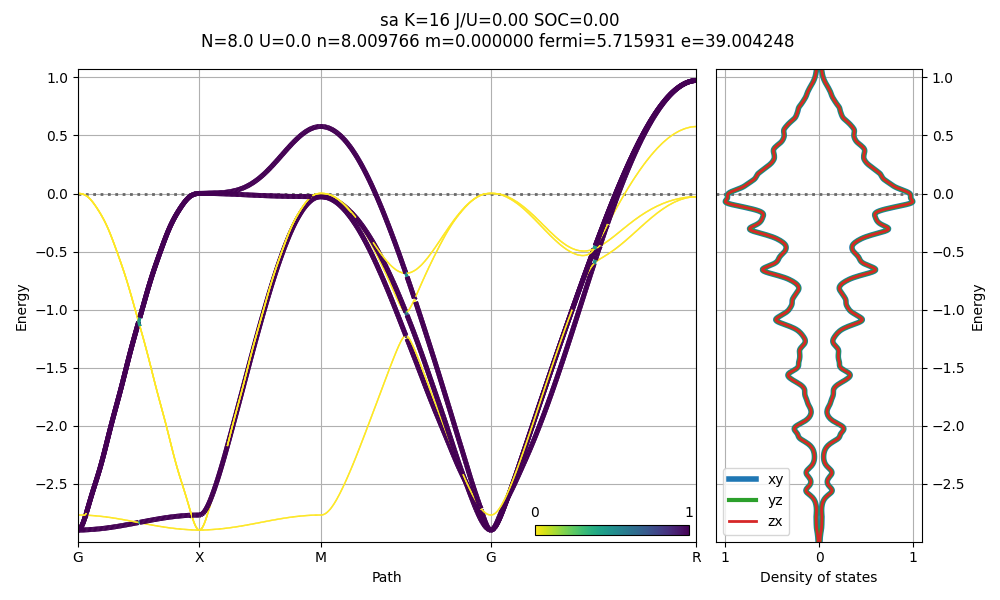

In [26]:
Image.open('/home/9yelin9/hf3/boo/diagram_v1/K16_JU0.00_SOC0.00/banduf_sa_N8.0_U0.0_n8.009766_m0.000000_fermi5.715931_e39.004248_811178.png')

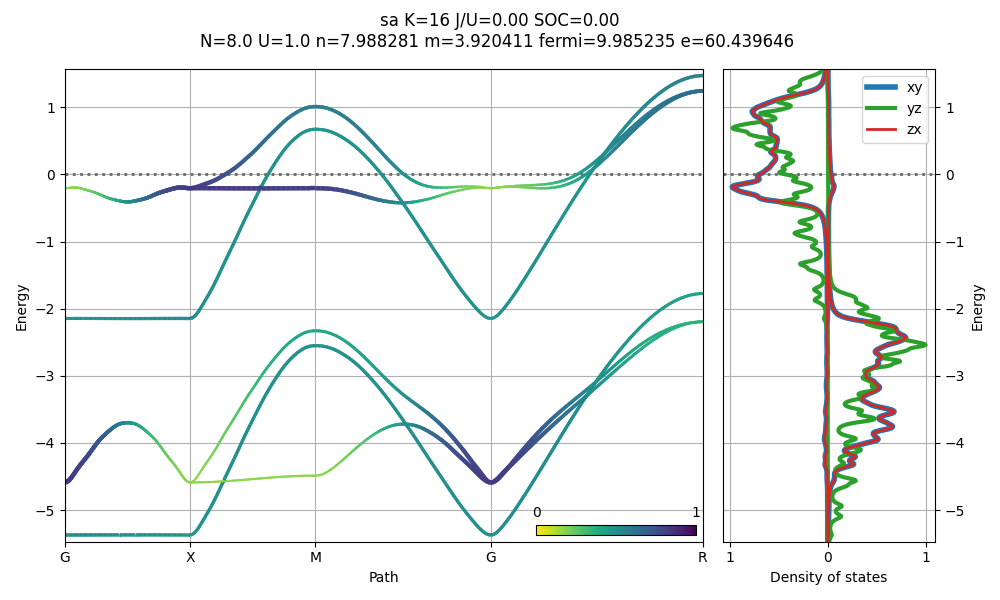

In [27]:
Image.open('/home/9yelin9/hf3/boo/diagram_v1/K16_JU0.00_SOC0.00/banduf_sa_N8.0_U1.0_n7.988281_m3.920411_fermi9.985235_e60.439646_811178.png')

In [28]:
df = pd.read_csv('output_v1/highsym.csv')
df.drop(df.loc[:, 'wG0.1':'eG11.1'], axis=1, inplace=True) # drop duplicated columns
df.drop(['K', 'JU', 'SOC', 'N', 'U', 'fermi'], axis=1, inplace=True) # drop conditions
df

,type,wG0,wG1,wG2,wG3,wG4,wG5,wG6,wG7,wG8,...,eR2,eR3,eR4,eR5,eR6,eR7,eR8,eR9,eR10,eR11
0,sa,2.818540,2.818540,2.818540,2.818540,2.818540,2.818540,2.948144,2.948144,5.717356,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,sa,2.835532,2.835532,2.835923,2.835923,2.835923,2.835923,2.965136,2.965136,5.734739,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,sa,2.852915,2.852915,2.852915,2.852915,2.853306,2.853306,2.982910,2.982910,5.751731,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,sc,2.818540,2.818540,2.818540,2.818540,2.818540,2.818540,5.688976,5.688976,5.688976,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,sa,2.870102,2.870102,2.870102,2.870102,2.870688,2.870688,3.000292,3.000292,5.768919,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,sa,11.077547,11.077547,11.077547,11.077547,11.077967,11.077967,11.207760,11.207760,13.976366,...,0.000005,0.000005,0.000078,0.000078,0.999995,0.999995,0.999995,0.999995,0.999922,0.999922
18404,sa,11.473408,11.473408,11.474056,11.474056,11.474056,11.474056,11.603236,11.603236,14.372876,...,0.000006,0.000006,0.000092,0.000092,0.999908,0.999908,0.999994,0.999994,0.999994,0.999994
18405,sa,11.864118,11.864118,11.864118,11.864118,11.864527,11.864527,11.994443,11.994443,14.762940,...,0.000008,0.000008,0.000128,0.000128,0.999992,0.999992,0.999992,0.999992,0.999872,0.999872
18406,sa,12.257403,12.257403,12.257403,12.257403,12.257773,12.257773,12.387817,12.387817,15.156227,...,0.000011,0.000011,0.000182,0.000182,0.999988,0.999988,0.999989,0.999989,0.999818,0.999818


<AxesSubplot:>

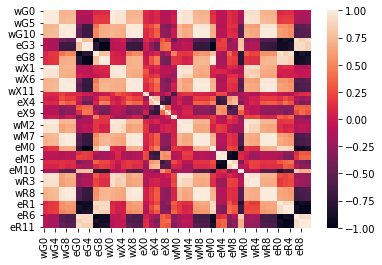

In [29]:
# show correlation

corr = df.corr()
sns.heatmap(corr) # corr 큰 순서대로 정렬하면 좋음

we can find some repeating shape in correlation matrix. <br>
so let's take a look at specific high symmetry point.

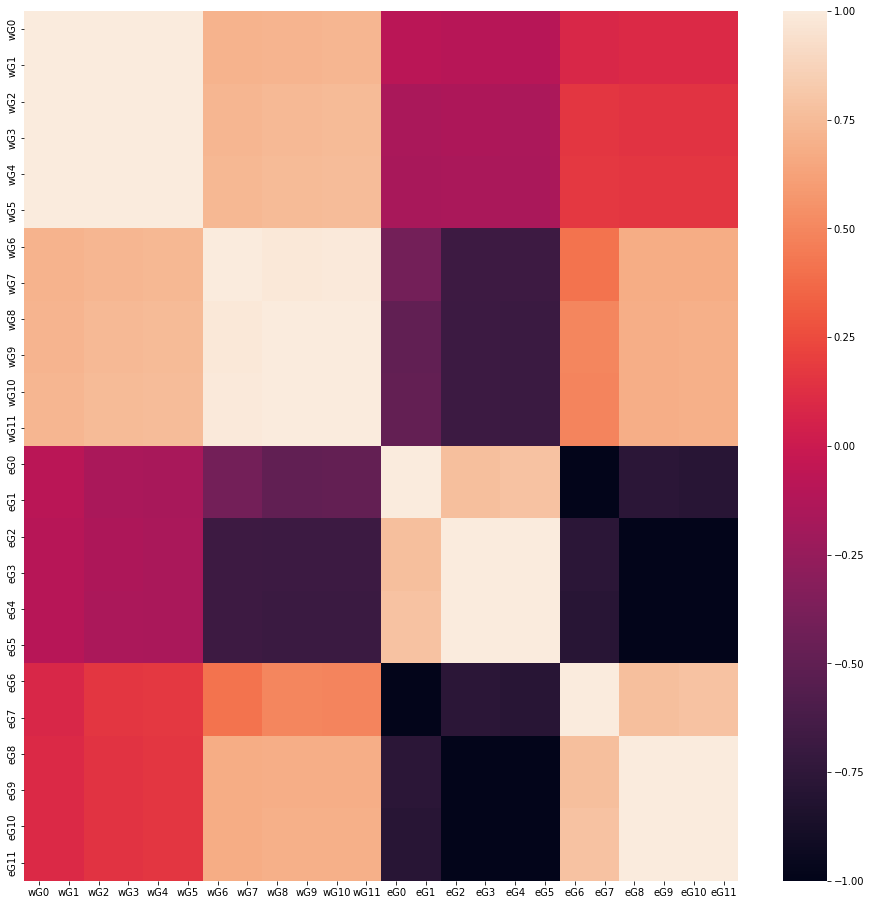

In [30]:
# show correlation of G point and other features

corr = df.loc[:, :'eG11'].corr()
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, ax=ax)
plt.show()

some features are highly correlated -> can be reduced by PCA

## 2. Classification using Random Forest
data scaling is not crucial to RF, so let's run it first

In [31]:
# run Random Forest

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['type'], axis=1).values
y = df['type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

rf = RandomForestClassifier(criterion='gini', random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [32]:
def DrawImportances(rf, feature_names):
    importances = pd.Series(rf.feature_importances_, index=feature_names)
    importances_w = importances.copy()
    for fn in feature_names:
        if not re.match('w', fn): importances_w[fn] = 0

    fig, ax = plt.subplots(figsize=(16, 6))
    importances.plot.bar(ax=ax, color='tab:blue')
    importances_w.plot.bar(ax=ax, color='tab:orange')
    ax.set_xticklabels(feature_names)
    ax.set_title("Feature importances")
    fig.tight_layout()
    plt.show()

Accuracy : 1.000
Precision : 1.000
Recall : 1.000


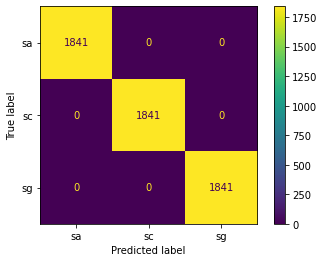

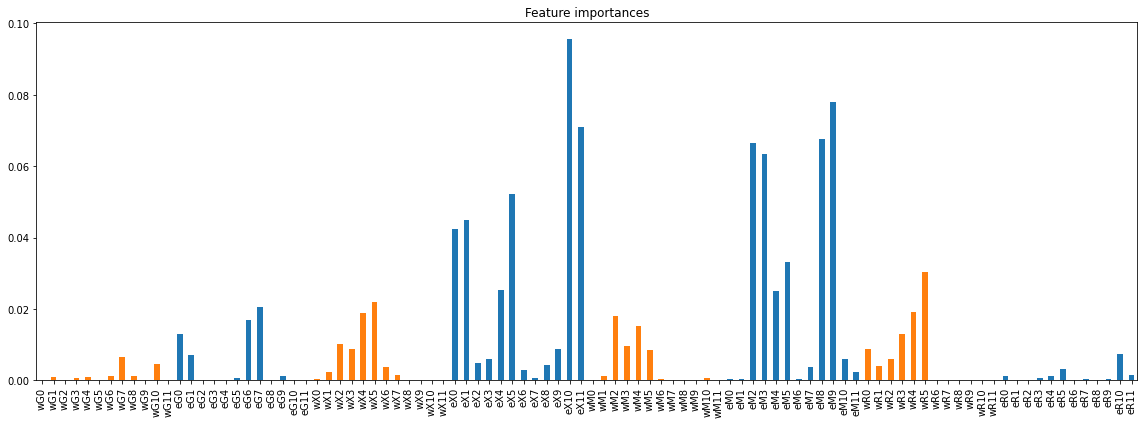

In [33]:
# check performance

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

print('Accuracy : %.3f\nPrecision : %.3f\nRecall : %.3f' % (accuracy_score(y_test, y_pred),\
                                                            precision_score(y_test, y_pred, average='micro'),\
                                                            recall_score(y_test, y_pred, average='micro')))

feature_names = list(df.columns)
feature_names.remove('type')

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
DrawImportances(rf, feature_names)

~unfolding weight is considered important in RF.~ <br>
after reducing range of U and dU, energy is considered important in RF. <br>
but RF can't distinguish highly correlated features, so maybe other features correlated with weight are also important too!

## 3. Data preprocessing
scaling

In [34]:
X = df.drop(['type'], axis=1).values
y = df['type'].values

# scailing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

X_std = sc_std.fit_transform(X)
X_mm  = sc_mm.fit_transform(X)

## 4. PCA (Principal Component Analysis)
data has 103 features -> too many! <br>
for better classification, we should reduce features by using PCA

In [35]:
def DrawVariance(pca, n_components):
    print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))
    
    plt.bar(range(n_components), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(n_components), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')

    plt.show()

[0.51708843 0.22768225 0.10887431 0.0614142  0.02805461 0.01751749
 0.01127105 0.00671023 0.00540876 0.00283407] 0.9868553994925683


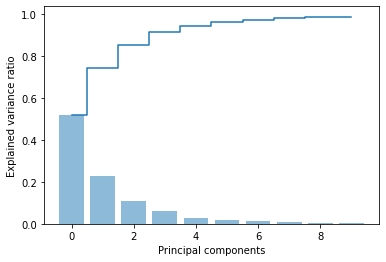

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_std)

DrawVariance(pca, 10)

using 10 principal components can explain original data's variance upto 98%. <br>
so let's find optimal PC num by Scree plot!

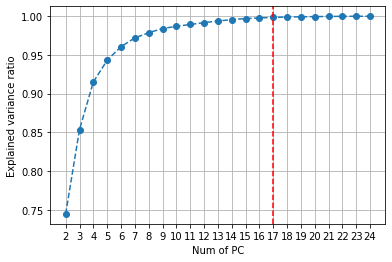

In [37]:
n_list = np.arange(2, 25, 1)
v_list = []

for n in n_list:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_std)
    v_list.append(np.sum(pca.explained_variance_ratio_))
    
pca_num = 17
    
fig, ax = plt.subplots()
ax.plot(n_list, v_list, 'o--')
ax.axvline(x=pca_num, color='r', ls='--')
ax.set_xticks(n_list)
ax.set_xlabel('Num of PC')
ax.set_ylabel('Explained variance ratio')
ax.grid(True)
plt.show()

just using **17** PC can explain original data!

<AxesSubplot:>

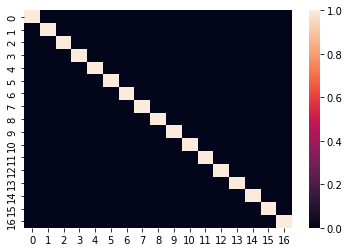

In [38]:
pca = PCA(n_components=pca_num)
X_pca = pca.fit_transform(X_std)

corr = pd.DataFrame(X_pca, index=range(len(X_pca))).corr()
sns.heatmap(corr)

no correlation between PCs

### 4.1. Clustering with 3 PC
Clustering model : sklearn KMeans

In [39]:
def DrawScat(X_pca, clus_num=1):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    if clus_num > 1:
        for i in range(clus_num):
            X_tmp = X_pca[X_pca['clus'] == i]
            ax.scatter(X_tmp['pc1'], X_tmp['pc2'], X_tmp['pc3'], s=2, label=i)
            ax.legend()
            del X_tmp
    else:
        ax.scatter(X_pca['pc1'], X_pca['pc2'], X_pca['pc3'], s=2)
            
    ax.set_xlabel('pc1')
    ax.set_ylabel('pc2')
    ax.set_zlabel('pc3')
    ax.set_title('Scatter plot with 3 PC')

    plt.show()

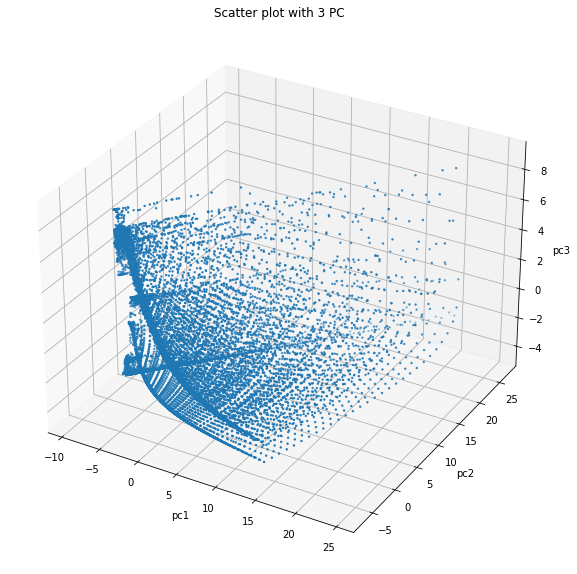

In [40]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_std)

X_pca = pd.DataFrame(X_pca, index=range(len(X_pca)), columns=['pc1', 'pc2', 'pc3'])

DrawScat(X_pca)

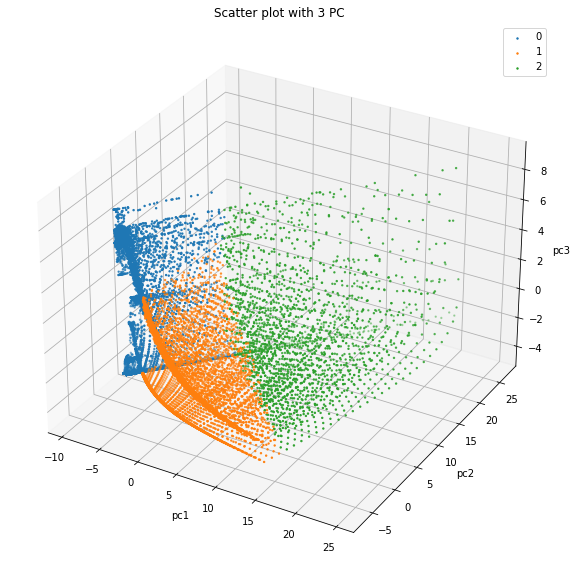

In [41]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=1)
X_pca['clus'] = km.fit_predict(X_pca)

DrawScat(X_pca, 3)

In [42]:
data_size = len(y)

types = ['sa', 'sc', 'sg']
type_list = list(itertools.permutations(types, 3))

for t in type_list:
    y_pred = X_pca['clus'].replace({0:t[0], 1:t[1], 2:t[2]})
    data_true = 0
    
    for i in range(data_size):
        if y[i] == y_pred[i]: data_true += 1
            
    print(t, '%.2f' % (data_true/data_size))

('sa', 'sc', 'sg') 0.30
('sa', 'sg', 'sc') 0.27
('sc', 'sa', 'sg') 0.37
('sc', 'sg', 'sa') 0.30
('sg', 'sa', 'sc') 0.40
('sg', 'sc', 'sa') 0.36


Clustering is not good choice for predicting magnetic structure.

## 5. Classification

In [43]:
pca = PCA(n_components=pca_num)
X_pca = pca.fit_transform(X_std)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, stratify=y, random_state=1)

In [44]:
# Random Forest

rf = RandomForestClassifier(criterion='gini', random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Accuracy : 1.000
Precision : 1.000
Recall : 1.000


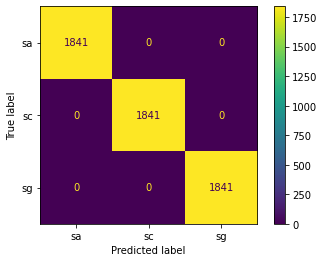

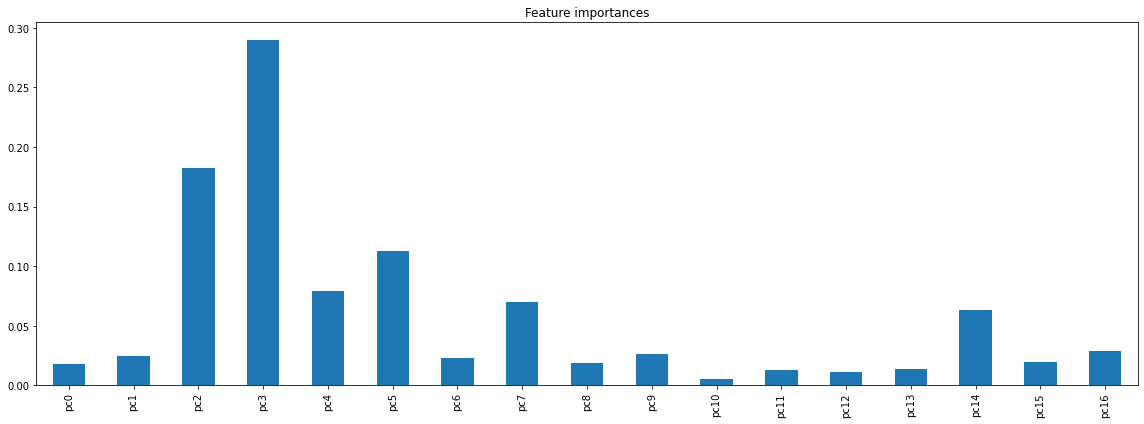

In [45]:
print('Accuracy : %.3f\nPrecision : %.3f\nRecall : %.3f' % (accuracy_score(y_test, y_pred),\
                                                            precision_score(y_test, y_pred, average='micro'),\
                                                            recall_score(y_test, y_pred, average='micro')))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
DrawImportances(rf, ['pc%d' % (i) for i in range(pca_num)])

In [46]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

Accuracy : 1.000
Precision : 1.000
Recall : 1.000


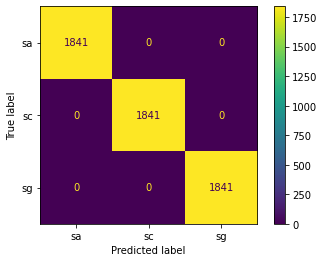

In [47]:
print('Accuracy : %.3f\nPrecision : %.3f\nRecall : %.3f' % (accuracy_score(y_test, y_pred),\
                                                            precision_score(y_test, y_pred, average='micro'),\
                                                            recall_score(y_test, y_pred, average='micro')))

ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)